# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.22 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import workspace_utils
from workspace_utils import active_session
import matplotlib.pyplot as plt
%matplotlib inline

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.09749999782070518


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from model import Actor, Critic
from ddpg_agent import Agent

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=99)

Using:  cuda:0


In [9]:
def ddpg(n_episodes=1000, max_t=10000):
    """DDQN Algorithm.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): frequency of printing information throughout iteration """
    
    scores = []
    time_stamp = 0
    scores_deque = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        #state = env_info.vector_observations[0]            # get the current state
        states = env_info.vector_observations # get states for all the agents
        #score = 0
        score = np.zeros(num_agents)
        
        for t in range(max_t):
            #action = agent.act(state)          # select an action
            actions = agent.act(states)    # select actions for all agents
       
            #env_info = env.step(action)[brain_name]        # send the action to the environment
            env_info = env.step(actions)[brain_name]    # send an action for every agent to the environment
            #next_state = env_info.vector_observations[0]   # get the next state
            next_states = env_info.vector_observations    # get the next states for each agent
            #reward = env_info.rewards[0]                   # get the reward
            rewards = env_info.rewards    # get the reward for each agent
            #done = env_info.local_done[0]                  # see if episode has finished
            dones = env_info.local_done    # check all agents to see if their episodes are finished
            
            #agent.step(state, action, reward, next_state, done) # take step with agent (including learning)
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, time_stamp)
            
            #score += reward                                # update the score
            score += rewards    # update the score for each agent
            time_stamp += 1
            #state = next_state                             # roll over the state to next time step
            states = next_states    # update the state for each agent
            
            #if done:                                       # exit loop if episode finished
            if np.any(dones):    # exit the loop if any of the episodes are finished
                break
        
        #scores_deque.append(score)       # save most recent score
        scores_deque.append(np.mean(score))
        #scores.append(score)             # save most recent score
        scores.append(np.mean(score))

  #      print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)))
        print('\rEpisode {}\tMean Score: {:.2f}\tMoving Average Score: {:.2f}'.format(i_episode, np.mean(score), np.mean(scores_deque)))
        
  #      print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} Episodes \tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

In [10]:
with active_session():
    scores = ddpg(n_episodes = 1000)

Episode 1	Mean Score: 0.88	Moving Average Score: 0.88
Episode 2	Mean Score: 1.33	Moving Average Score: 1.11
Episode 3	Mean Score: 1.93	Moving Average Score: 1.38
Episode 4	Mean Score: 2.24	Moving Average Score: 1.60
Episode 5	Mean Score: 1.47	Moving Average Score: 1.57
Episode 6	Mean Score: 0.71	Moving Average Score: 1.43
Episode 7	Mean Score: 1.73	Moving Average Score: 1.47
Episode 8	Mean Score: 2.48	Moving Average Score: 1.60
Episode 9	Mean Score: 2.26	Moving Average Score: 1.67
Episode 10	Mean Score: 2.73	Moving Average Score: 1.78
Episode 11	Mean Score: 2.78	Moving Average Score: 1.87
Episode 12	Mean Score: 3.61	Moving Average Score: 2.01
Episode 13	Mean Score: 5.77	Moving Average Score: 2.30
Episode 14	Mean Score: 5.89	Moving Average Score: 2.56
Episode 15	Mean Score: 5.41	Moving Average Score: 2.75
Episode 16	Mean Score: 6.85	Moving Average Score: 3.00
Episode 17	Mean Score: 8.05	Moving Average Score: 3.30
Episode 18	Mean Score: 9.89	Moving Average Score: 3.67
Episode 19	Mean Sco

Episode 146	Mean Score: 30.57	Moving Average Score: 25.26
Episode 147	Mean Score: 32.83	Moving Average Score: 25.46
Episode 148	Mean Score: 32.51	Moving Average Score: 25.66
Episode 149	Mean Score: 31.86	Moving Average Score: 25.83
Episode 150	Mean Score: 34.78	Moving Average Score: 26.04
Episode 151	Mean Score: 30.62	Moving Average Score: 26.18
Episode 152	Mean Score: 30.09	Moving Average Score: 26.33
Episode 153	Mean Score: 30.71	Moving Average Score: 26.50
Episode 154	Mean Score: 34.78	Moving Average Score: 26.71
Episode 155	Mean Score: 34.14	Moving Average Score: 26.92
Episode 156	Mean Score: 33.30	Moving Average Score: 27.14
Episode 157	Mean Score: 35.15	Moving Average Score: 27.37
Episode 158	Mean Score: 31.54	Moving Average Score: 27.55
Episode 159	Mean Score: 34.19	Moving Average Score: 27.74
Episode 160	Mean Score: 35.37	Moving Average Score: 27.93
Episode 161	Mean Score: 36.93	Moving Average Score: 28.14
Episode 162	Mean Score: 34.80	Moving Average Score: 28.33
Episode 163	Me

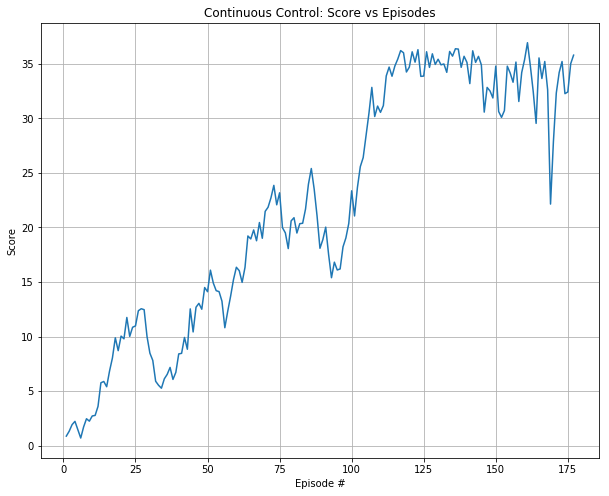

In [11]:
# plot the scores
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('Continuous Control: Score vs Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid(True)
plt.savefig("score.jpg")
plt.show()

In [12]:
env.close()